In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from matplotlib.pyplot import figure #bigger figure


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #disable tensorflow warnings

In [3]:

def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df



def pred_covid(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model('LSTM_GRU_Oct23_relu/' + model_name +'_infected_only_Oct23_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    #y_pred = model.predict(x_input) # too much warnings
    y_pred = model(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    #print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    #print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

In [4]:
df = read_from_source()
#df = df.append({'Date':pd.to_datetime('2021-10-31'),'Infected':4284}, ignore_index = True) #anomaly
#df = df.append({'Date':pd.to_datetime('2021-11-01'),'Infected':5000}, ignore_index = True) #anomaly
#df = df.append({'Date':pd.to_datetime('2021-11-02'),'Infected':354}, ignore_index = True) #anomaly

df

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
670,2021-11-16,147.0
671,2021-11-17,199.0
672,2021-11-18,159.0
673,2021-11-19,153.0


In [5]:
pred_arr = []

def pred_covid_for_xgb(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model('LSTM_GRU_Oct23_relu/' + model_name +'_infected_only_Oct23_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    #start editing
    window_size = 14
    for i in range(len(df) - window_size + 1):
        #print(df[i: i + window_size])
        #print(df['Date'][i],'-------', df['Date'][i + window_size])
        x_input = df[i: i + window_size]['Infected'].values # last 14 day
    
        #x_input = df['Infected'][-n_steps_in:].values # last 14 day
    # edit stops

        x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
        x_input = x_input.reshape((1, n_steps_in, 1))

        #y_pred = model.predict(x_input) # too much warnings
        y_pred = model(x_input)
        y_pred = sc.inverse_transform(y_pred) #revert scaling

        next_day = str(df['Date'][i + window_size+1])[:10]
        next_day_pred = int(y_pred[0][0])
        #print('Next day',next_day)
        #print('Next day prediction:', y_pred[0][0])
        
        pred_next_day = [next_day, next_day_pred]
        pred_arr.append(pred_next_day)
        #print(pred_next_day,'\n')
        

In [6]:
%%time
pred_covid_for_xgb('GRU', df, 3)

GRU loaded


KeyError: 675

In [7]:
pred_arr = np.array(pred_arr)
print(pred_arr.shape)
pred_arr

(660, 2)


array([['2020-01-31', '0'],
       ['2020-02-01', '5'],
       ['2020-02-02', '0'],
       ...,
       ['2021-11-18', '172'],
       ['2021-11-19', '234'],
       ['2021-11-20', '104']], dtype='<U10')

In [8]:
df_pred = pd.DataFrame(pred_arr, columns = ['Date','Predicted'])
print(df_pred.shape)
df_pred['Predicted'] = df_pred['Predicted'].astype(int)
df_pred

(660, 2)


,Date,Predicted
0,2020-01-31,0
1,2020-02-01,5
2,2020-02-02,0
3,2020-02-03,3
4,2020-02-04,0
...,...,...
655,2021-11-16,135
656,2021-11-17,170
657,2021-11-18,172
658,2021-11-19,234


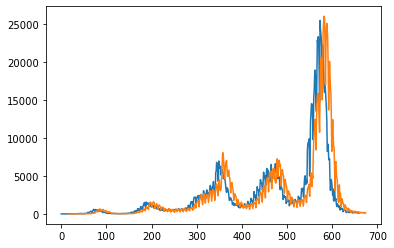

In [9]:
plt.plot(df_pred['Predicted'])
plt.plot(df['Infected'][15:])

In [10]:
df_pred.to_csv('pred_gru_3.csv',index = False)